In [1]:
# loading necessary libraries

import os, sys
import logging
import json
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import math

from collections import Counter

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to EST time.

In [2]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

# get the strings of all the filenames for file reading
for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)

# data directory preset
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
data_dir = "./proximity_2019-06-01/"

# Pre-processing

In [3]:
# read beacon and member metadata
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
members_metadata.dropna()
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')

In [4]:
# read member background data, merge to the original member metadata to keep consistent
background = pd.read_excel(data_dir+'Badge assignments_Attendees_2019.xlsx')
cleaned_members = members_metadata.merge(background, how='inner')

# separate out the member key strings of people who actually attended the meeting and those who did not
attendees_key = set(cleaned_members['member'])
all_people_key = set(members_metadata['member'])
attendees_id = set(cleaned_members['id'])
all_people_id = set(members_metadata['id'])

non_attendees_key = all_people_key-attendees_key
non_attendees_id = all_people_id-attendees_id

## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for every time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

For each of the variable, we concatnate the processed data from 17 proximity files into one Pandas Series/DataFrame, and do analysis based on it.

In [5]:
idmaps = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))
        
# tmp_idmaps = idmaps[0]
# for i in range(1, len(idmaps)):
#     tmp_idmaps = pd.concat([tmp_idmaps, idmaps[i]])

In [6]:
# # idmap_beacon = tmp_idmaps
# startmin = 25
# for i in beacons_metadata[['key', 'id']].iterrows():
#     beacon_id = i[1][1]
#     beacon_key = i[1][0]
    
#     tmp = pd.DataFrame(['2019-06-01 14:{}:00-04:00'.format(startmin), beacon_id, beacon_key]).transpose()
#     startmin += 1
#     tmp.columns = ['datetime', 'id', 'member']
# #     idmap_beacon = pd.concat([idmap_beacon, tmp])

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [7]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone))
        
# tmp_m2badges = m2badges[0]

# for i in range(1, len(m2badges)):
#     tmp_m2badges = pd.concat([tmp_m2badges, m2badges[i]])

In [8]:
cleaned_m2badges = []

for m2badge in m2badges:
    drop_list = []
    tmp = m2badge.reset_index()

    for index, row in tmp.iterrows():
        if row['member'] in non_attendees_key:
            drop_list.append(index)
        else:
            if row['observed_id'] in non_attendees_id:
                drop_list.append(index)
    tmp = tmp.drop(drop_list)
    cleaned_m2badges.append(tmp)

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [9]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(cleaned_m2badges, idmaps):
    m2ms.append(ob.preprocessing.member_to_member_proximity(m2badge, idmap))
    
tmp_m2ms = m2ms[0]
for i in range(1, len(m2ms)):
    tmp_m2ms = pd.concat([tmp_m2ms, m2ms[i]])

In [10]:
# Member to location beacon
m2bs = []
for m2badge in cleaned_m2badges:
    m2bs.append(ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))
    
tmp_m2bs = m2bs[0]
for i in range(1, len(m2bs)):
    tmp_m2bs = pd.concat([tmp_m2bs, m2bs[i]])

 Member 5 closest beacons

In [11]:
m5cb = tmp_m2bs.reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(20, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

Next, we extract voltage data from the files. This information can be used for monitoring purposes and for identifying badges that ran out of power prematurely.

# Basic examples

## Example 1 - Network graph
This example shows how to build a basic proximity network using the badge data.

In [12]:
tmp_m2ms_sorted = tmp_m2ms.sort_index(0,0)

In [13]:
# create time slices of four breakout sessions for future usage
breakout1 = slice('2019-06-01 09:50', '2019-06-01 10:39')
breakout2 = slice('2019-06-01 10:40', '2019-06-01 11:30')
breakout3 = slice('2019-06-01 13:10', '2019-06-01 13:59')
breakout4 = slice('2019-06-01 14:00', '2019-06-01 14:50')

# Filter data from specific time period

time_slice = slice('2019-06-01 10:00', '2019-06-01 10:00')
m2m_breakout = tmp_m2ms_sorted.loc[breakout1]

# keep only instances with strong signal
m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -70].copy()
print(len(m2m_filter_rssi))

4441


In [14]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 5]
print(len(m2m_edges))

# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")

224


In [15]:
# set colors by region
regions = members_metadata["region"].unique()
len_regions = len(regions)
value_map = {}
for i in range(0,len_regions):
    value_map[regions[i]] = i * (1.0/(len_regions-1))

In [16]:
# Add node information. Assign color
for index, row in cleaned_members.iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map.get(region)
    if member in graph.nodes():        
        graph.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph, 'color').iteritems()]

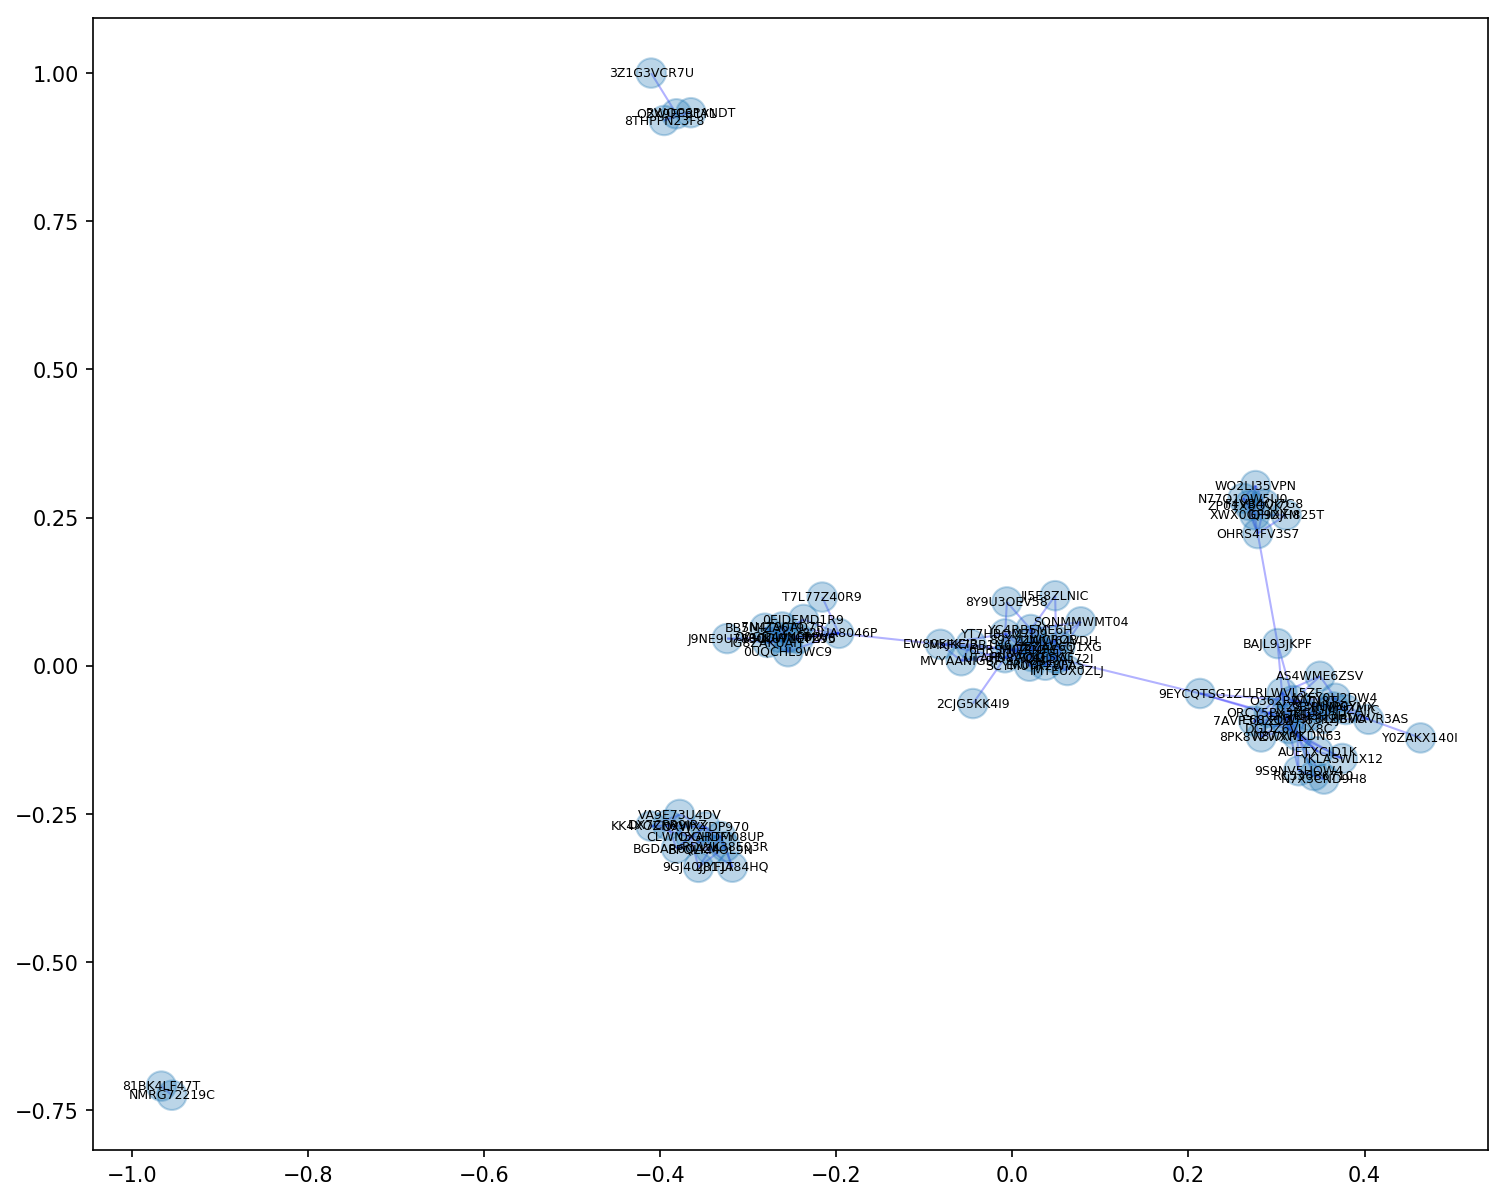

In [17]:
def draw_graph(G, graph_layout='shell',
               node_size=200, node_color='blue', node_alpha=0.3,
               node_text_size=6,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif', draw_name=True):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)
        
    
    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('tab10'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)

    if draw_name:
        nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                                font_family=text_font)


    plt.show()

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph, graph_layout="spring", node_color = node_colors)

## Example 3 - Closest Beacon Localization
This example places each badge near the closest beacon for each time interval. You can immediately see that the teams spent more of the time in the classrom, but head a breakout session in the afternoon (different teams went ot different rooms).

You can also see that some badges stayed at the reception area for the majority of the time - these badges belong to participants who did not show up for the event, and should therefore be removed from the analysis.

In [18]:
# update the memebr metadata with new index
members_metadata_m = cleaned_members.set_index('member')
beacons_metadata_b = beacons_metadata.set_index('beacon')

In [19]:
# Take the closest beacon for each member
closest = m5cb[0].rename('beacon')

In [20]:
# Go from closest beacon to location using the metadata
locations = closest.to_frame().join(beacons_metadata_b['location'], on='beacon')

# Join people's region for sorting
locations = locations.join(members_metadata_m['region'])

# Add the region to the index
locations = locations.reset_index().set_index(['datetime', 'region', 'member']).sort_index()

locations = locations['location']
locations.head()

datetime                   region  member    
2019-06-01 00:00:00-04:00  Team1   2CJG5KK4I9    Cafe
                                   2JYFJA84HQ    Cafe
                                   3G3F81BBVO    Cafe
                                   6FI0Z5BPM9    Cafe
                                   7AVP31LZU1    Cafe
Name: location, dtype: object

In [21]:
def time_location_plot(time_locations, ax=None, cmap=None, freq='30min', datetime_format='%H:%M'):
    """Plots the location of individuals/groups of individuals as a function of time.
    
    Parameters
    ----------
    time_locations : pd.Series
        The locations, indexed by 'datetime' and another index (e.g. member, group, ...).
    
    ax : matplotlib axes
        The axes on which to plot.
    
    cmap : matplotlib.colors.Colormap or str
        The colormap used by matplotlib.
    
    freq : str
        The frequency of ticks on the x-axis.  Defaults to '30min'.
    
    datetime_format : str
        The way time is formatted with `strftime` on the x-axis.
        See https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
        for more information.
    """

    # Pivot the dataframe to have datetime vs member
    pivoted = time_locations.unstack(0)

    # The list of locations
    locations = sorted(set(time_locations))
    N = len(locations)

    # Select a colormap (either passed, string or default)
    if cmap is None:
        cmap = plt.get_cmap('tab10')  # Default colormap
    elif type(cmap) is str:
        cmap = plt.get_cmap(cmap)

    if ax is None:
        ax = plt.gca()  # Use current axes if none were provided

    # Construct a colormap based on `cmap` that matches the number of different locations,
    # and displays `None` as white
    cmap = mpl.colors.ListedColormap([(1.0, 1.0, 1.0)] + list(cmap.colors), N=N+1)

    # Map locations to integers, to be used by `pcolor`
    mapping = {loc: i+1 for (i, loc) in enumerate(locations)}
    pivoted = pivoted.applymap(lambda x: mapping.get(x, 0))

    # Create the time-location diagram
    coll = ax.pcolormesh(pivoted, cmap=cmap)

    # Vertical axis, with the people
    ax.set_yticks(np.arange(0.5, len(pivoted.index), 1))
    ax.set_yticklabels(pivoted.index)

    # Horizontal axis, with the dates
    xlabels = pd.date_range(pivoted.columns[0], pivoted.columns[-1], freq=freq)
    ax.set_xticks([pivoted.columns.get_loc(idx, method='nearest') for idx in xlabels])
    ax.tick_params(axis='x',labelsize=20)
    ax.set_xticklabels(xlabels.strftime(datetime_format), rotation=45, ha='right')

    # Add a colorbar, with one tick per location
    cbar = ax.figure.colorbar(coll, use_gridspec=False,
                              anchor=(-.2, 0.5), aspect=30,
                              boundaries=np.arange(0, N+1)+.5)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_ticks(np.arange(1., N+1, 1.))
    cbar.set_ticklabels(locations)

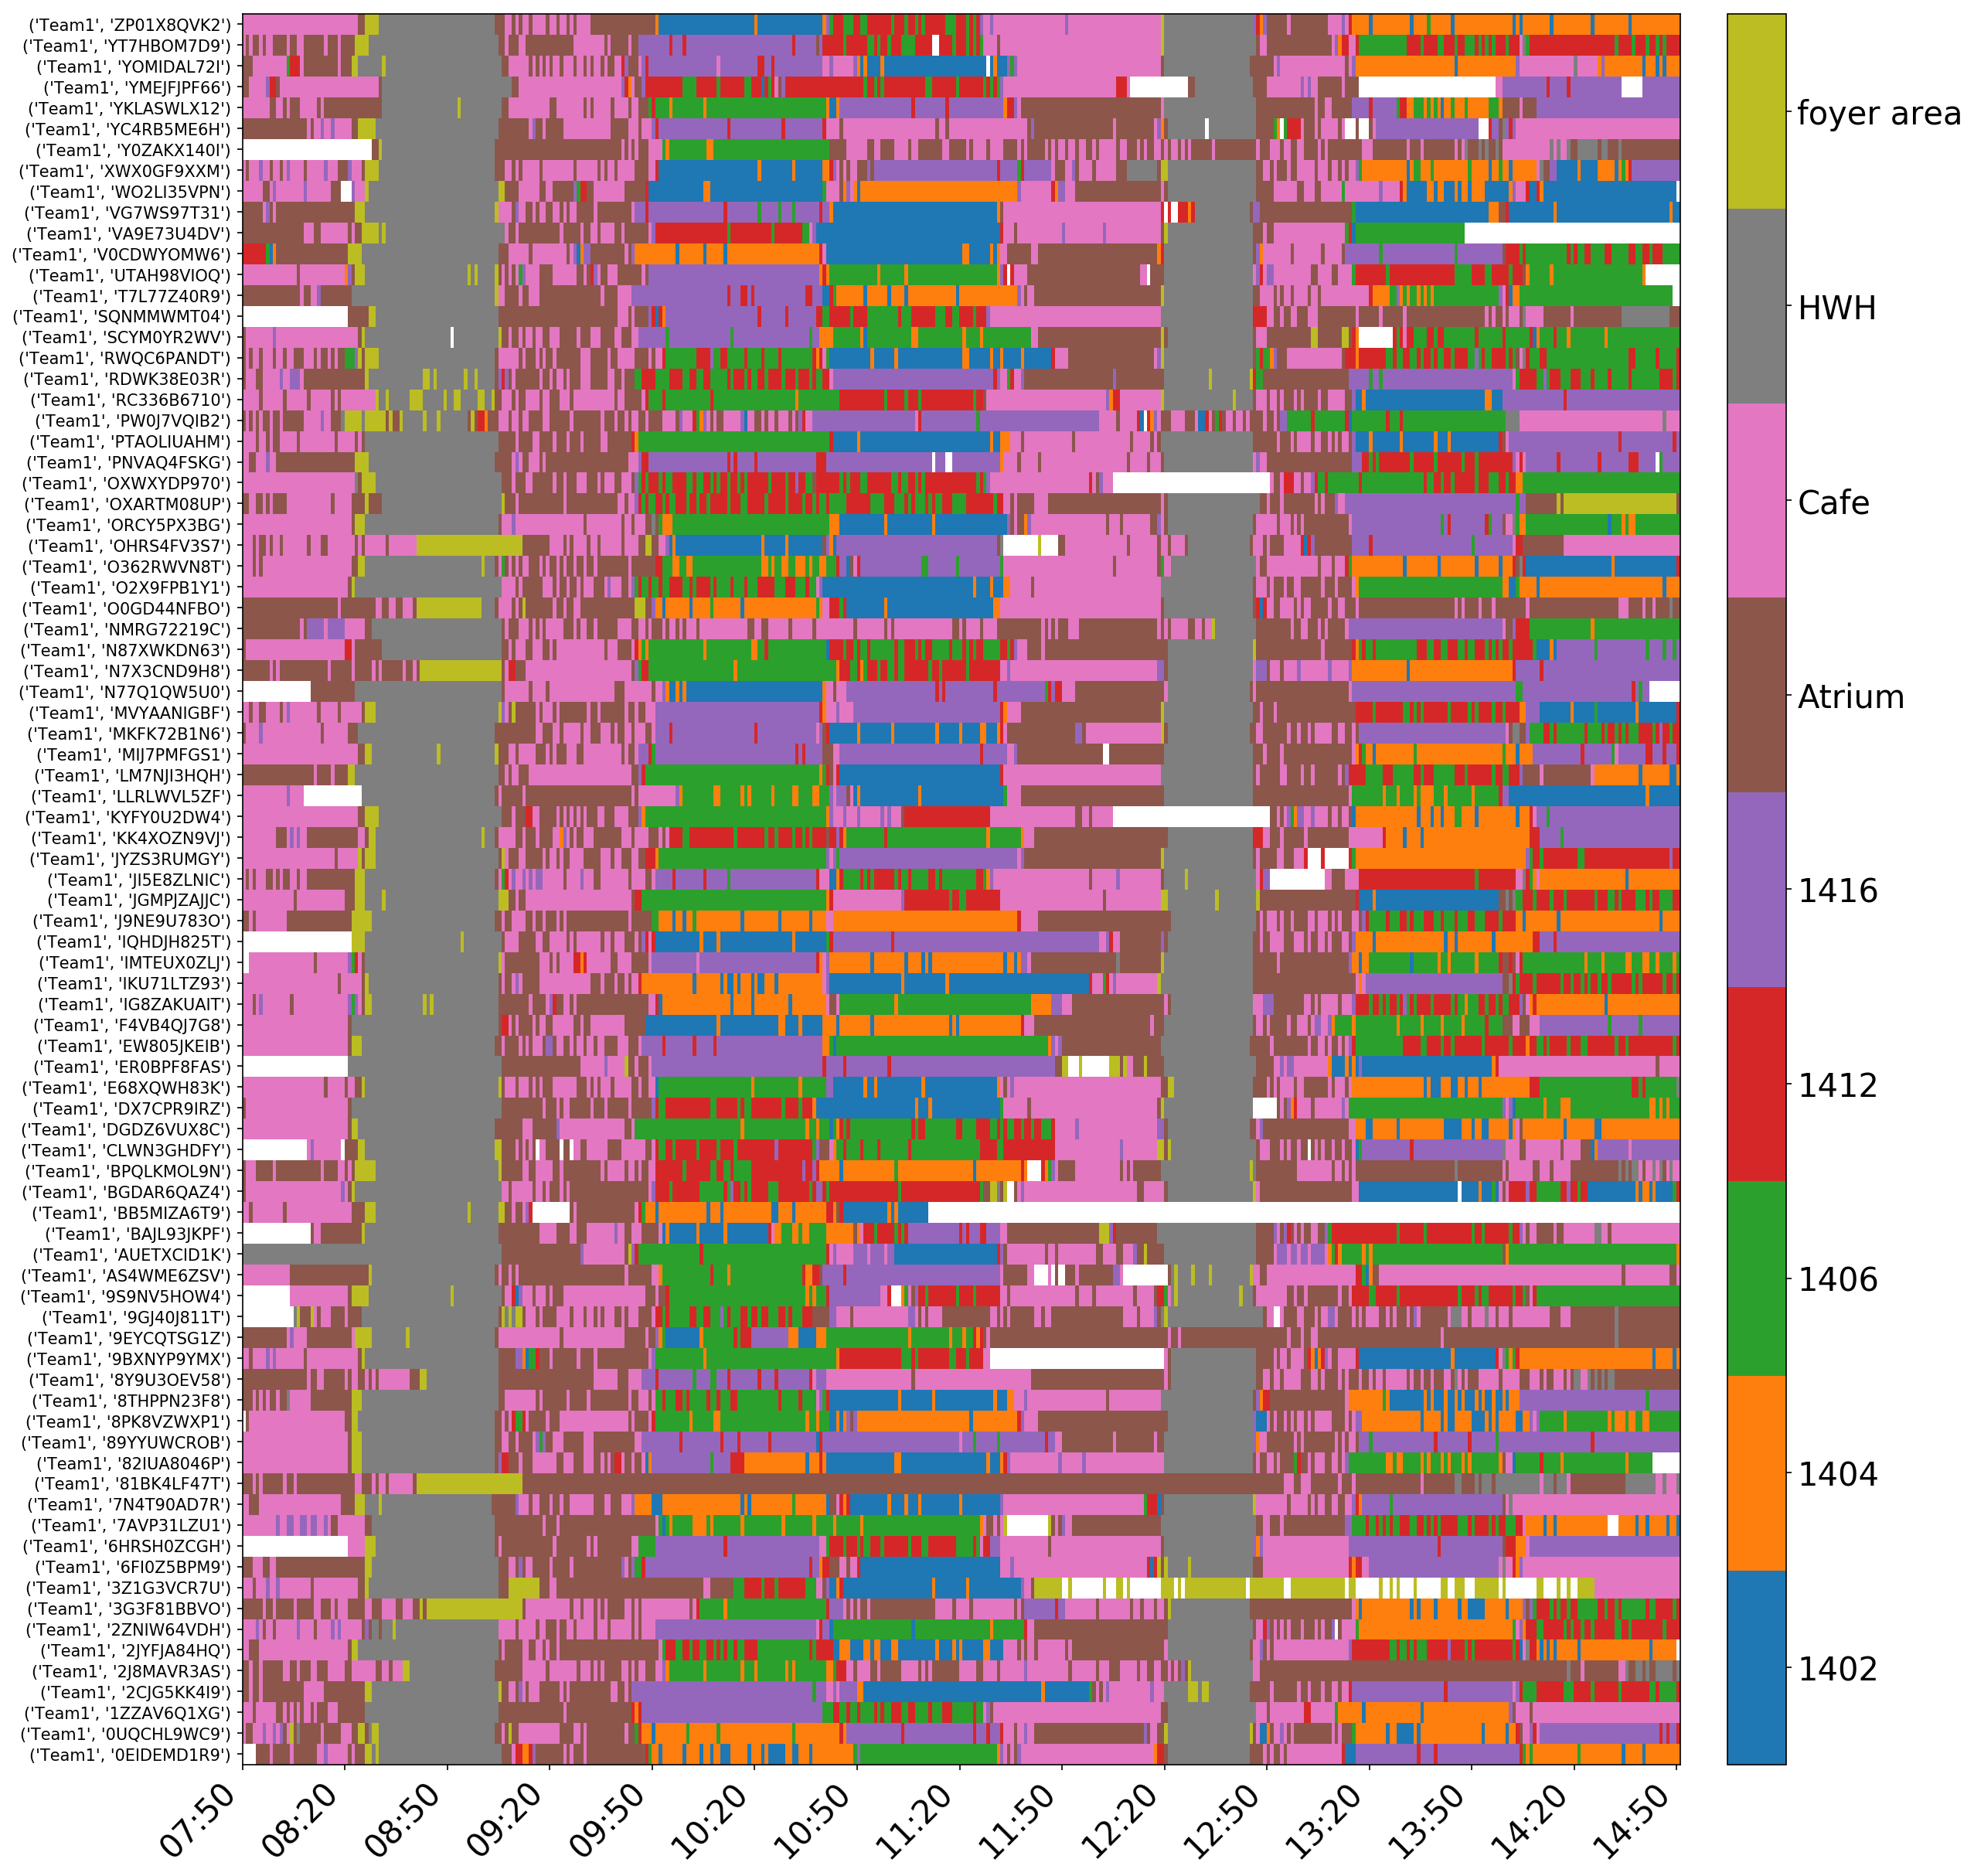

In [22]:
# The time slice for displaying the heatmap
time_slice = slice('2019-06-01 07:50', '2019-06-01 14:50')

# Plotting
fig = plt.figure(figsize=(20, 20), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(locations.loc[time_slice])

plt.show()

# Cleaning Closest Beacon Plot

In [23]:
# generate a time slice starting with the given time with length "duration"
def generate_time_slices_by_duration(start_h, start_m, duration):
    start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    duration_h = (int)(duration/60)
    duration_m = duration % 60
    if duration_m + start_m > 60:
        duration_h += 1
        duration_m = (duration_m+start_m) % 60
        end = '2019-06-01 {:02}:{:02}'.format(start_h+duration_h, duration_m-1)
        return start_h+duration_h, duration_m-1, slice(start, end)
    else:
        end = '2019-06-01 {:02}:{:02}'.format(start_h+duration_h, duration_m+start_m-1)
        return start_h+duration_h, duration_m+start_m-1, slice(start, end)

    
# create time slices between start time and end time by every "interval" minute(s)
def generate_time_slices_by_interval(start_h, start_m, end_h, end_m, interval=2):
    
    time_slices = []
    
    start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    duration = (end_h - start_h) * 60 + (end_m - start_m)
    
    for i in range(duration/interval+1):
        
        if start_h > end_h:
            break
        elif start_h == end_h:
            if start_m > end_m:
                break
            
        tmp_h = start_h
        tmp_m = start_m
        
        if tmp_m < 60-interval+1:
            tmp_m += interval-1
        else:
            tmp_h += 1
            if interval > 1:
                tmp_m = tmp_m - 60 + interval-1
            else:
                tmp_m = tmp_m - 60 + interval
            
        tmp_time = '2019-06-01 {:02}:{:02}'.format(tmp_h, tmp_m)
        
        time_slices.append(slice(start, tmp_time))
        
        start_h = tmp_h
        start_m = tmp_m
        
        if start_m == 59:
            start_h += 1
            start_m = 0
        else:
            start_m += 1
        
        start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    return time_slices

In [24]:
# create 8 half-breakout session time slices, saved in variable half_breakout_sessions

# 1st two halfs
total_start_h = 9
total_start_m = 50
half_breakout_sessions = []
for i in range(2):
    total_start_h, total_start_m, ts = generate_time_slices_by_duration(total_start_h, total_start_m, 23)
    total_start_m += 1
    half_breakout_sessions.append(ts)
    
# 2nd two halfs
total_start_m += 4
total_start_h += (int)(total_start_m/60)
total_start_m = total_start_m % 60
for i in range(2):
    total_start_h, total_start_m, ts = generate_time_slices_by_duration(total_start_h, total_start_m, 23)
    total_start_m += 1
    half_breakout_sessions.append(ts)

# 3rd two halfs
total_start_h = 13
total_start_m = 10
for i in range(2):
    total_start_h, total_start_m, ts = generate_time_slices_by_duration(total_start_h, total_start_m, 23)
    total_start_m += 1
    half_breakout_sessions.append(ts)
    
# 4th two halfs
total_start_m += 4
total_start_h += (int)(total_start_m/60)
total_start_m = total_start_m % 60
for i in range(2):
    total_start_h, total_start_m, ts = generate_time_slices_by_duration(total_start_h, total_start_m, 23)
    total_start_m += 1
    half_breakout_sessions.append(ts)

In [25]:
# get the room assignment for each member in each half-breakout session

df_half_breakout = []
for time_slice in half_breakout_sessions:
    df_half_breakout.append(locations.loc[time_slice].reset_index())
    
member_keys = set(pd.DataFrame(locations).reset_index()['member'].unique())

location_dict_half_breakout = []

for i in range(8):
    tmp = df_half_breakout[i]
    tmp_dict = {}
    for j in member_keys:
        tmp_dict.setdefault(j, [])
    for row in tmp.iterrows():
        tmp_key = row[1][2]
        tmp_room = row[1][3]

        tmp_dict[tmp_key].append(tmp_room)
    location_dict_half_breakout.append(tmp_dict)

cleaned_dict = dict()
for i in member_keys:
    cleaned_dict.setdefault(i, [])

for i in range(8):
    tmp_dict = location_dict_half_breakout[i]
    
    for member in list(member_keys):
        member_hist = tmp_dict[member]
        c = Counter(member_hist)
        
        if len(c.most_common(1)) > 0:
            if c.most_common(1)[0][1] < 6:
                continue        
            cleaned_dict[member].append(c.most_common(1)[0][0])

In [26]:
df_locations1 = locations[breakout1].reset_index()
df_locations2 = locations[breakout2].reset_index()
df_locations3 = locations[breakout3].reset_index()
df_locations4 = locations[breakout4].reset_index()

df_location_list = [df_locations1, df_locations2, df_locations3, df_locations4]


location_dict1 = dict()
location_dict2 = dict()
location_dict3 = dict()
location_dict4 = dict()
for i in member_keys:
    location_dict1.setdefault(i, [])
    location_dict2.setdefault(i, [])
    location_dict3.setdefault(i, [])
    location_dict4.setdefault(i, [])


location_dict_list = [location_dict1, location_dict2, location_dict3, location_dict4]

for i in range(4):
    for rows in df_location_list[i].iterrows():
        tmp_key = rows[1][2]
        tmp_room = rows[1][3]
        location_dict_list[i][tmp_key].append(tmp_room)

        
tmp = dict()
for i in member_keys:
    tmp.setdefault(i, [])
cleaned_dict_list = [tmp]*4

for i in range(4):
    
    tmp_dict = location_dict_list[i]
    
    for member in list(member_keys):
        member_hist = tmp_dict[member]
        c = Counter(member_hist)
        
        if len(c.most_common(1)) > 0:
            if c.most_common(1)[0][1] < 12:
                continue        
            tmp[member].append(c.most_common(1)[0][0])
            
# add "not here"
for member in tmp.keys():
    if len(tmp[member]) < 4:
        add =  4 - len(tmp[member]) 
        for i in range(add):
            tmp[member].append('Not Here')



In [27]:
room_assignment1_a = []
room_assignment2_a = []
room_assignment3_a = []
room_assignment4_a = []

for row in members_metadata.iterrows():
    member = row[1][0]
    cleaned_dict_list[0].setdefault(member, ['Not Here','Not Here','Not Here','Not Here'])
    room_assignment1_a.append(cleaned_dict_list[0][member][0])
    room_assignment2_a.append(cleaned_dict_list[0][member][1])
    room_assignment3_a.append(cleaned_dict_list[0][member][2])
    room_assignment4_a.append(cleaned_dict_list[0][member][3])
    
members_metadata1 = members_metadata.copy()
members_metadata1['region'] = room_assignment1_a

In [28]:
members_metadata_m1 = members_metadata1.set_index('member')


# Go from closest beacon to location using the metadata
locations1 = closest.to_frame().join(beacons_metadata_b['location'], on='beacon')

# Join people's region for sorting
locations1 = locations1.join(members_metadata_m1['region'])

# Add the region to the index
locations1 = locations1.reset_index().set_index(['datetime', 'region', 'member']).sort_index()

locations1 = locations1['location']

cleaned_locations = locations1.copy()

# Cleaning first breakout session
for t in range(50):
    if t < 10:
        start1 = '2019-06-01 09:{}:00-04:00'.format(50+t)
    else:
        start1 = '2019-06-01 10:{}:00-04:00'.format(t-10)
    
    for member in cleaned_dict_list[0].keys():
        cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][0]
        
# Cleaning second breakout session
for t in range(51):
    if t < 20:
        start1 = '2019-06-01 10:{}:00-04:00'.format(40+t)
    else:
        start1 = '2019-06-01 11:{}:00-04:00'.format(t-20)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 1:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][1]
        
# Cleaning second breakout session
for t in range(50):
    start1 = '2019-06-01 13:{}:00-04:00'.format(10+t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 2:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][2]
        
# Cleaning second breakout session
for t in range(51):
    start1 = '2019-06-01 14:{}:00-04:00'.format(t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 3:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][3]


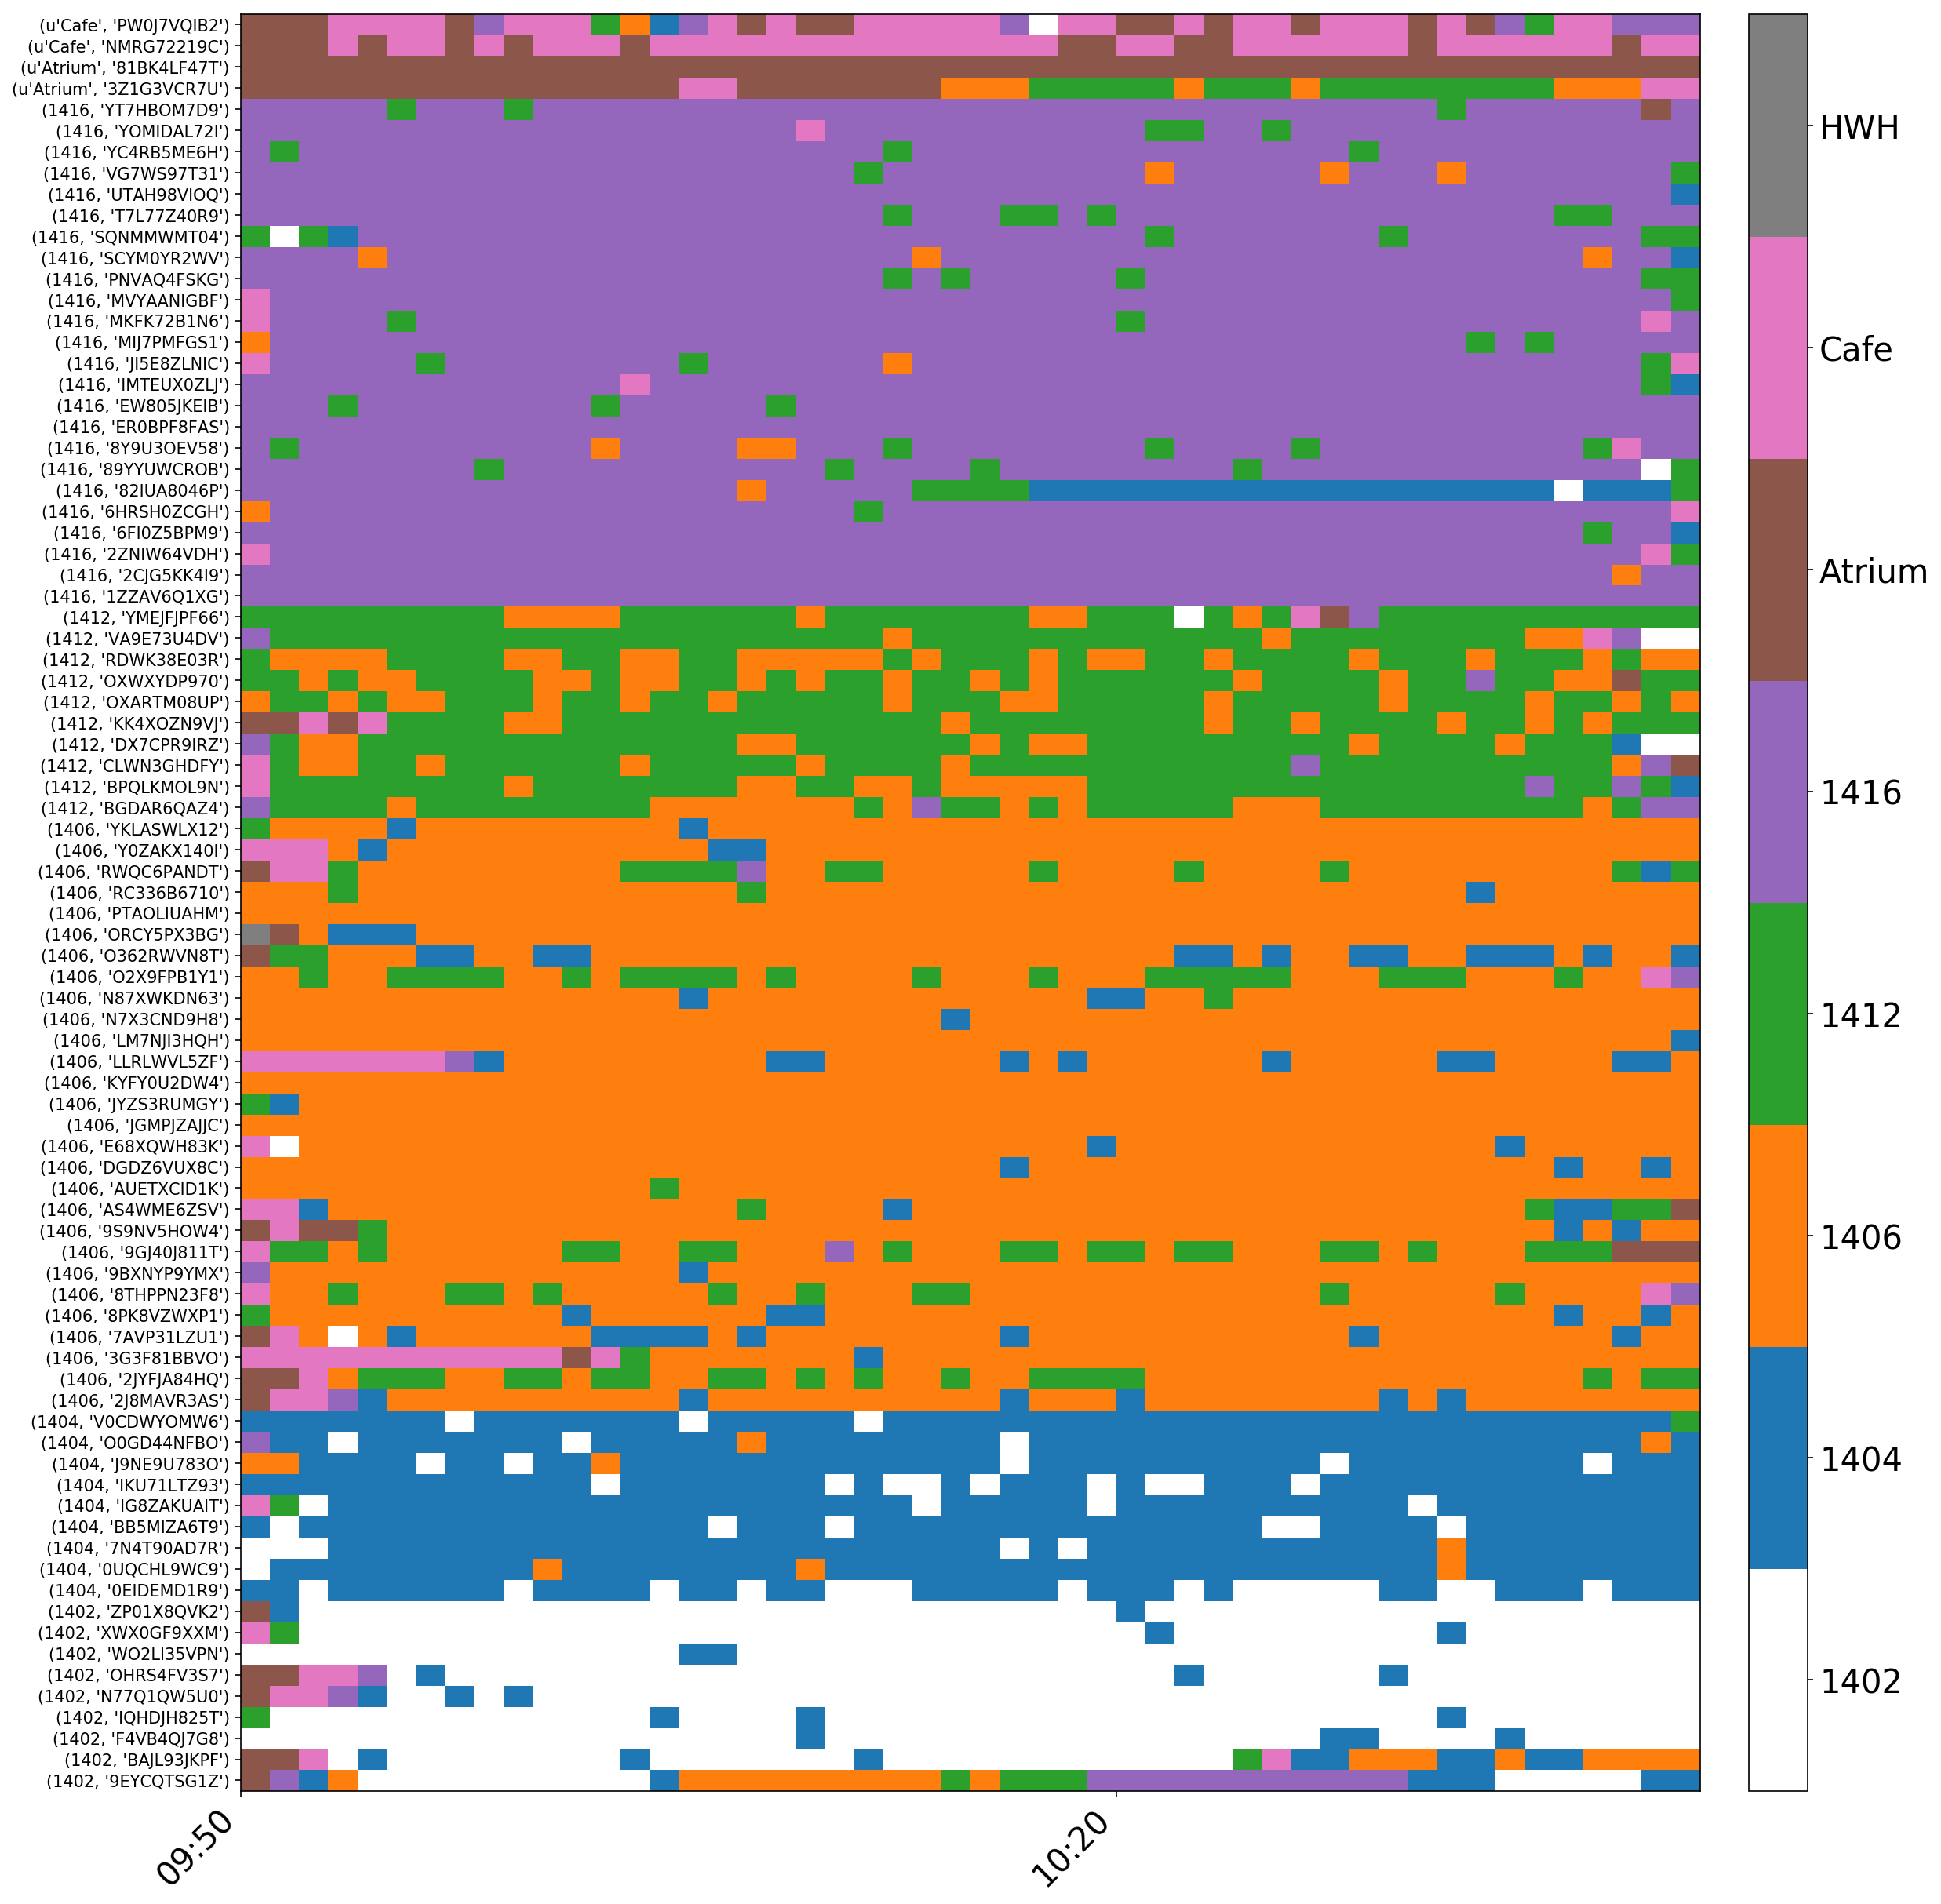

In [29]:
# Closest beacon graph for only 1st breakout session
# Plotting
fig = plt.figure(figsize=(20, 20), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(cleaned_locations.loc[breakout1].sort_values())

plt.show()

In [30]:
# add "not here"
for member in cleaned_dict.keys():
    if len(cleaned_dict[member]) < 8:
        add = 8 - len(cleaned_dict[member]) 
        for i in range(add):
            cleaned_dict[member].append('Not Here')

In [31]:
# extract room assignments of each half-breakout session
room_assignment1 = []
room_assignment2 = []
room_assignment3 = []
room_assignment4 = []
room_assignment5 = []
room_assignment6 = []
room_assignment7 = []
room_assignment8 = []

room_assignments = [room_assignment1,room_assignment2,room_assignment3, \
                    room_assignment4,room_assignment5,room_assignment6,room_assignment7, room_assignment8]


for row in cleaned_members.iterrows():
    member = row[1][0]
    cleaned_dict.setdefault(member, ['Not Here']*8)
    room_assignment1.append(cleaned_dict[member][0])
    room_assignment2.append(cleaned_dict[member][1])
    room_assignment3.append(cleaned_dict[member][2])
    room_assignment4.append(cleaned_dict[member][3])
    room_assignment5.append(cleaned_dict[member][4])
    room_assignment6.append(cleaned_dict[member][5])
    room_assignment7.append(cleaned_dict[member][6])
    room_assignment8.append(cleaned_dict[member][7])

    
member_metadatas = []
    
for i in range(8):
    tmp_member_metadata = cleaned_members.copy()
    tmp_member_metadata['region'] = room_assignments[i]
    member_metadatas.append(tmp_member_metadata.set_index('member'))



In [32]:
# Filter data from specific time period

SELECTED_HALF_BREAKOUT = 0

m2m_half_breakout1 = tmp_m2ms_sorted.loc[half_breakout_sessions[SELECTED_HALF_BREAKOUT]]
# m2m_half_breakout1 = tmp_m2ms_sorted.loc[breakout1]

# keep only instances with strong signal
m2m_filter_rssi1 = m2m_half_breakout1[m2m_half_breakout1.rssi >= -72].copy()
print(len(m2m_filter_rssi1))

3059


In [33]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges1 = m2m_filter_rssi1.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges1 = m2m_edges1[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges1 = m2m_edges1[m2m_edges1.weight > 1]
print(len(m2m_edges1))

# Create a graph
graph1=nx.from_pandas_edgelist(m2m_edges1, "member1", "member2", "weight")

300


In [34]:
# set colors by region
regions1 = member_metadatas[SELECTED_HALF_BREAKOUT]["region"].unique()
len_regions1 = len(regions1)
value_map1 = {}
for i in range(0,len_regions1):
    value_map1[regions1[i]] = i * (1.0/(len_regions1-1))

# Add node information. Assign color
for index, row in member_metadatas[SELECTED_HALF_BREAKOUT].reset_index().iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map1.get(region)
    if member in graph1.nodes():   
        graph1.add_node(member, region=region, color=color)
        
node_colors1 = [color for member,color in nx.get_node_attributes(graph1, 'color').iteritems()]
node_region1 = [region for member, region in nx.get_node_attributes(graph1, 'region').iteritems()]

In [35]:
# get the list of region and color following the order by which Networkx plots node
nc = []
nr = []
for key in list(graph1.nodes()):
    nc.append(nx.get_node_attributes(graph1, 'color')[key])
    nr.append(nx.get_node_attributes(graph1, 'region')[key])

In [36]:
# create a map from color to region for plotting legend
scalar2region = {}
for i in range(len(node_colors1)):
    scalar2region[nc[i]] = nr[i]

In [37]:
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# a modified draw_graph method with legend plotted
def draw_graph_legend(G, graph_layout='shell',
               node_size=200, node_color='blue', node_alpha=0.5,
               node_text_size=6,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif', draw_name=True):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)        
    
    cMap=plt.get_cmap('jet')
    
    
    tmp_nc = []
    tmp_nr = []
    for member in nx.get_node_attributes(G, 'region'):
        tmp_nc.append(nx.get_node_attributes(G, 'color')[member])
        tmp_nr.append(nx.get_node_attributes(G, 'region')[member])
    
    ncolor = cMap(tmp_nc)
    
    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size,
                           alpha=node_alpha, node_color=node_color,cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)

    if draw_name:
        nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                                font_family=text_font)
    
    mapping = {}
    for i in range(len(tmp_nc)):
        mapping[tmp_nc[i]] = tmp_nr[i]
        
    patches = []
    for i in range(len(mapping)):
        c = list(cMap(scalar2region.keys()[i]))
        c[-1] = node_alpha
    
        tmp_patch = mpatches.Patch(color=c, label=mapping[sorted(mapping.keys())[i]])
        patches.append(tmp_patch)
        
    plt.legend(handles=patches, fontsize=10)
    
    plt.show()

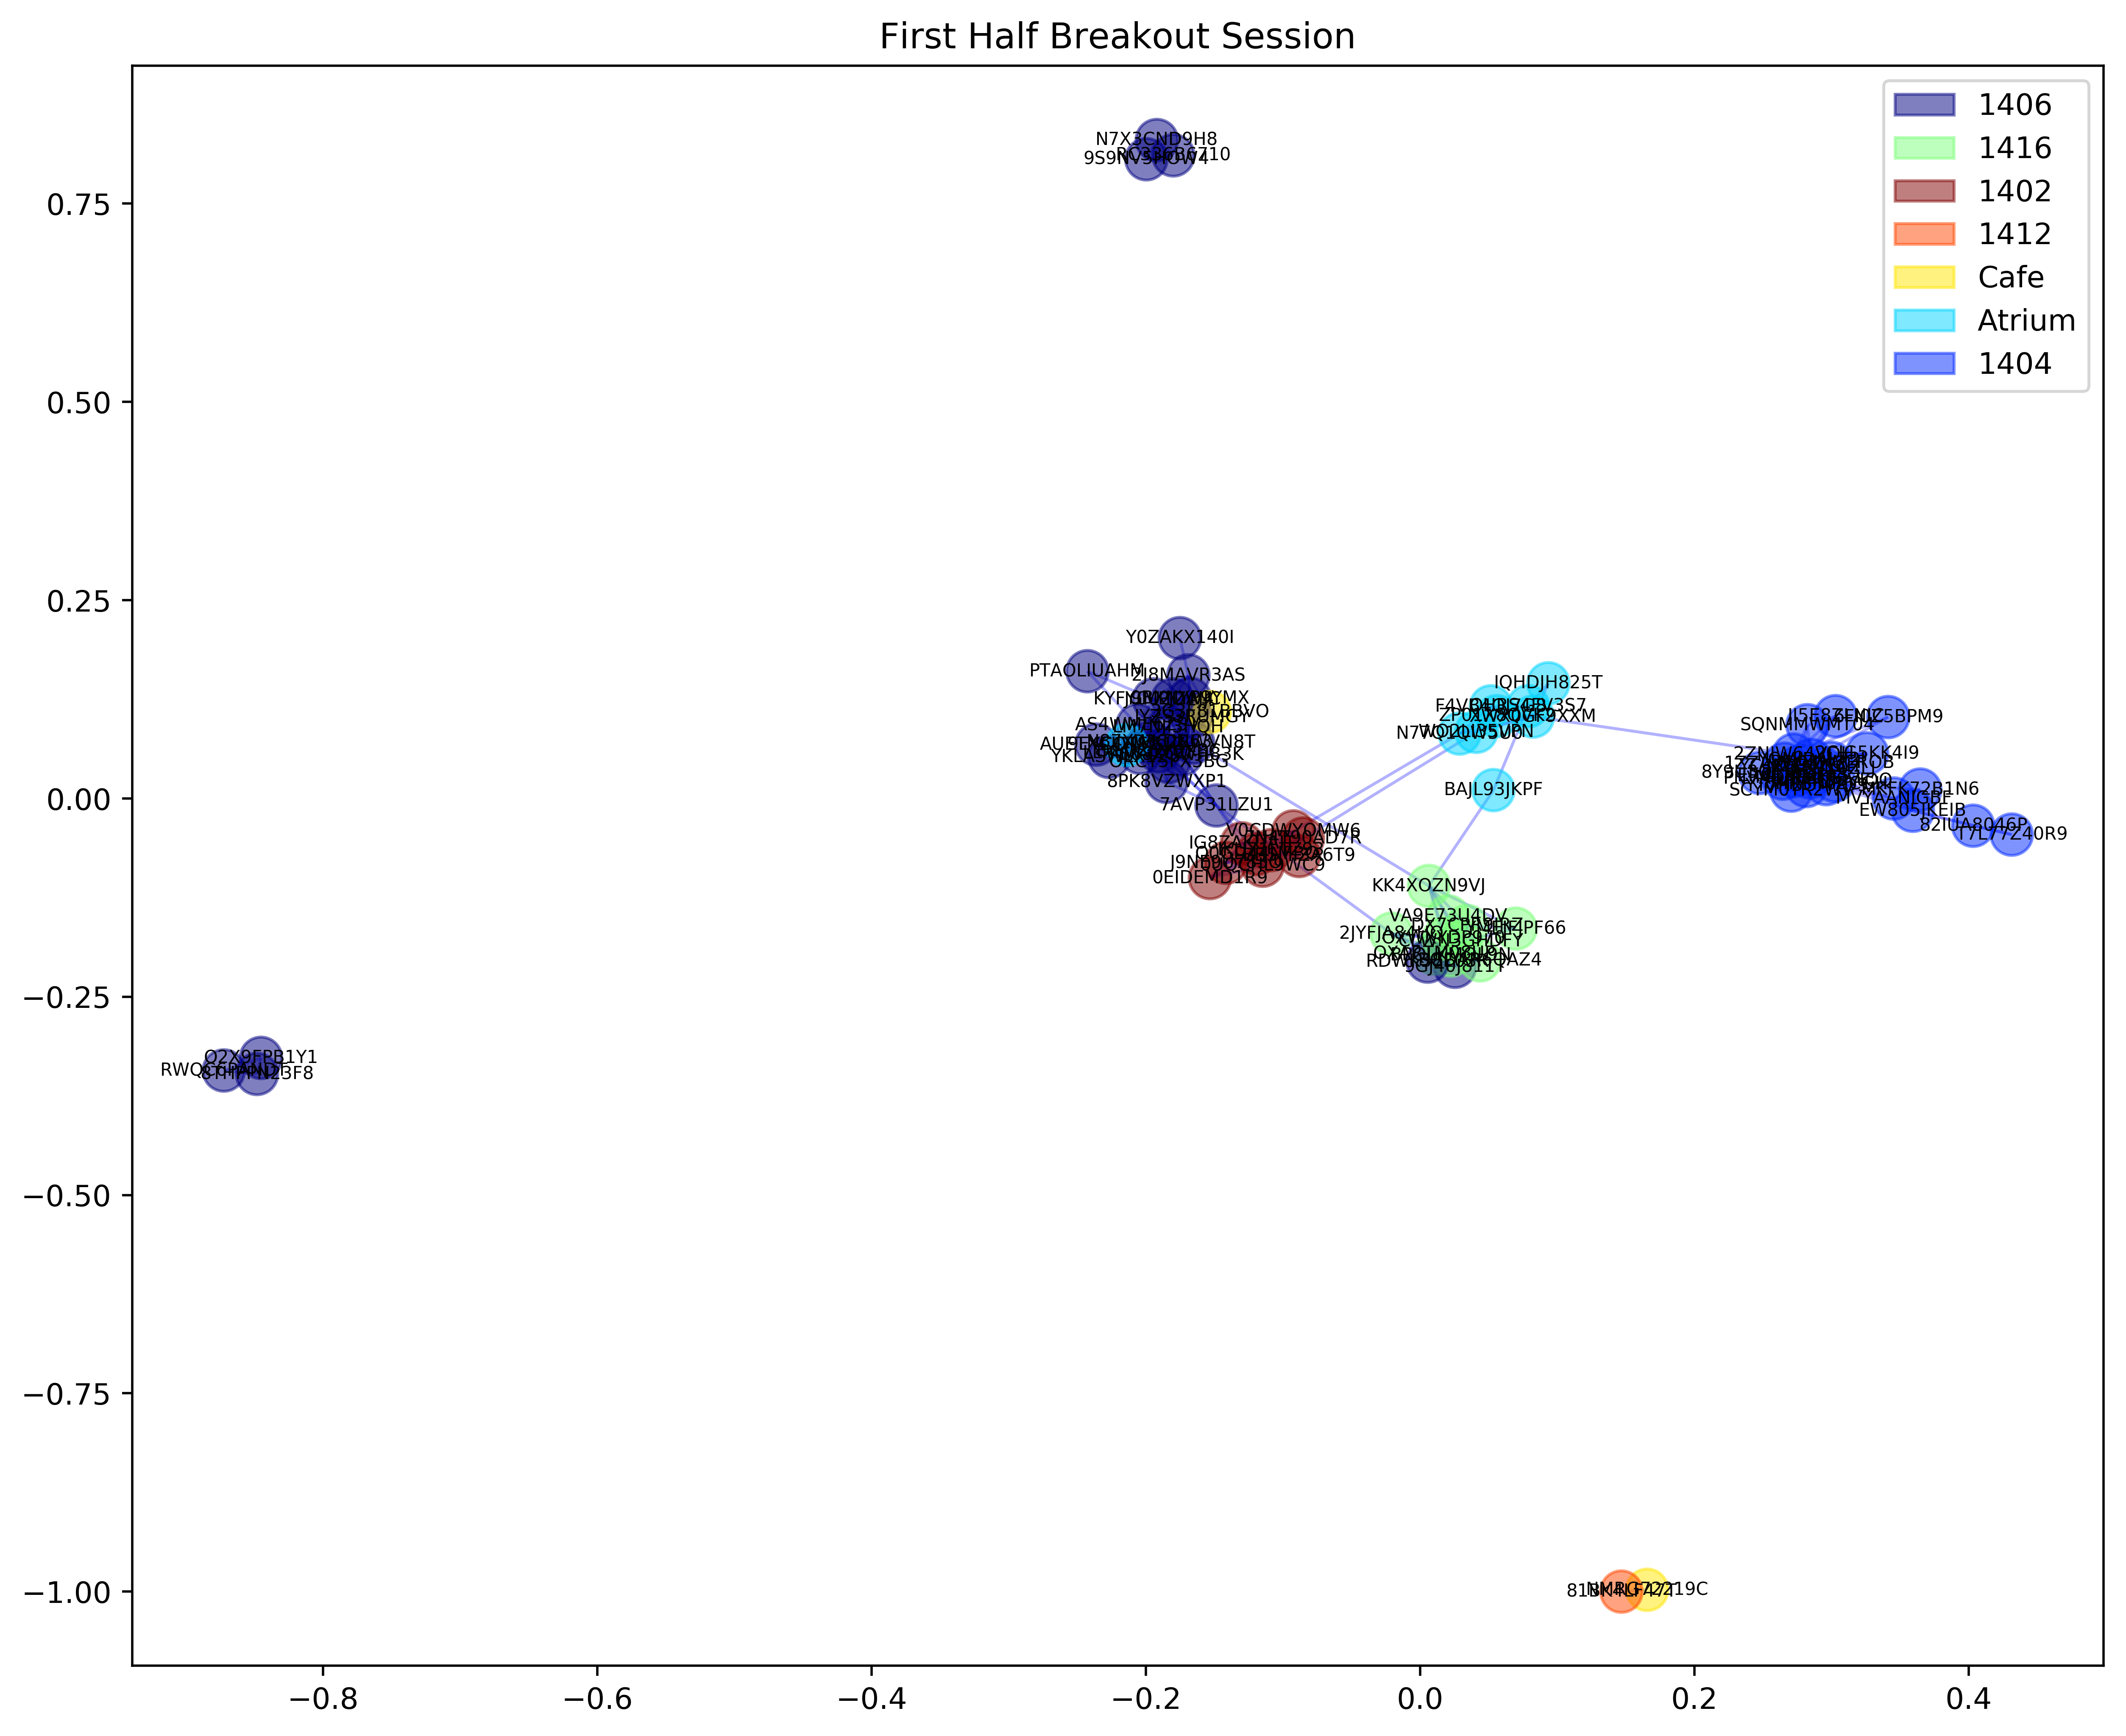

In [38]:
fig = plt.figure(figsize=(12, 10), dpi=500)
ax = plt.subplot(1,1,1)
plt.title('First Half Breakout Session')
draw_graph_legend(graph1, graph_layout="spring", node_color = nc, draw_name=True)

In [39]:
# by reversing the dictionary mapping from member to room, generate a new dictionary mapping from room to member
reversed_cleaned_dicts = []
for i in range(4):
    tmp_dict = {}
    for key in tmp.keys():
        room_of_member = tmp[key][i]
        if type(room_of_member) == int:
            tmp_dict.setdefault(room_of_member, [])
    for key in tmp.keys():
        room_of_member = tmp[key][i]
        if type(room_of_member) == int:
            tmp_dict[room_of_member].append(key)
    reversed_cleaned_dicts.append(tmp_dict)
    

In [40]:
# create plots showing the distributions of people's background in each room
for i in range(4):
    tmp_dict = reversed_cleaned_dicts[i]
    for room in tmp_dict.keys():
        tmp_list = []
        member_in_room = tmp_dict[room]
        for member in member_in_room:
            bg = cleaned_members[cleaned_members['member']==member]\
            ['Cleaned Primary discipline/field of interest.1'].values[0]
            tmp_list.append(bg)
        fig = plt.figure(figsize=(20, 11)
                        )   
        labels, values = zip(*Counter(tmp_list).items())
        indexes = np.arange(len(labels))
        width = 0.8

        plt.bar(indexes, values, width)
        plt.xticks(indexes, labels, rotation=30, fontsize=30)
        plt.yticks(fontsize=30)
        plt.annotate('# of People: {}'.format(len(tmp_list)), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=30)
        plt.title('Breakout Session {}'.format(i+1) + " Room {}".format(room), fontsize=20)
        plt.savefig('./topic_hist/' + 'Breakout Session {}'.format(i+1) + " Room {}".format(room) + '.png')        
        plt.close(fig)         